In [8]:
! pip install numpy panda matplotlib

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle  # For saving and loading Q-values

In [10]:
# Simulation parameters
NUM_DRONES = 5  # Number of drones in the simulation
GRID_SIZE = 20   # Size of the search grid
BETA = 1.5  # Softmax temperature parameter
ALPHA = 0.7  # Weight between individual and cooperative rewards
GAMMA = 0.9  # Discount factor for long-term rewards
LAMBDA = 0.1  # Energy consumption penalty
MAX_BATTERY = 100  # Maximum battery capacity per drone
CHARGING_STATION = (0, 0)  # Fixed charging station location
ITERATIONS = 100

# Priority map is now input, no need for discovery
PRIORITY_MAP = np.random.randint(1, 6, (GRID_SIZE, GRID_SIZE))  # Predefined heatmap
SEARCHED_MAP = np.zeros((GRID_SIZE, GRID_SIZE))  # Track searched areas

In [11]:
# Initialize Q-table
try:
    with open("q_values.pkl", "rb") as f:
        Q_TABLE = pickle.load(f)
except FileNotFoundError:
    Q_TABLE = np.zeros((GRID_SIZE, GRID_SIZE, 4))  # Q-values for each state-action pair
    with open("q_values.pkl", "wb") as f:
        pickle.dump(Q_TABLE, f)
        np.random.seed(42)  # For reproducibility
class Drone:
    def __init__(self, drone_id):
        self.id = drone_id  # Unique identifier for the drone
        self.state = (0,0)
        self.visited_states = [tuple(self.state)]  # Track visited states
        self.cumulative_reward = 0  # Keep track of total search priority collected
        self.battery = MAX_BATTERY  # Initialize battery life
        self.active = True  # Drone status
    
    def compute_reward(self, new_state):
        """ Compute reward with energy constraint """
        R_ind = PRIORITY_MAP[new_state[0], new_state[1]]
        R_coop = 1 / (1 + SEARCHED_MAP[new_state[0], new_state[1]])  # Incentivize unexplored areas
        E_cost = LAMBDA * (1 - (self.battery / MAX_BATTERY))  # Energy penalty
        return ALPHA * R_ind + (1 - ALPHA) * R_coop - E_cost
    
    def softmax_policy(self, available_actions):
        """ Select action based on softmax over Q-values """
        q_values = np.array([self.get_q_value(pos) for pos in available_actions])
        exp_q = np.exp(BETA * q_values)
        probabilities = exp_q / np.sum(exp_q)
        return available_actions[np.random.choice(len(available_actions), p=probabilities)]
    
    def get_q_value(self, state):
        """ Retrieve Q-value for a given state """
        return np.max(Q_TABLE[state[0], state[1], :])
    
    def update_q_value(self, state, reward):
        """ Update Q-table with the new experience """
        Q_TABLE[state[0], state[1], :] = reward + GAMMA * np.max(Q_TABLE[state[0], state[1], :])
    
    def take_action(self):
        """ action towards an area based on softmax action selection """
        if not self.active:
            return
        
        if self.battery <= 10:
            self.state = np.array(CHARGING_STATION)  # action to charging station
            self.battery = MAX_BATTERY  # Recharge battery
            self.visited_states.append(tuple(self.state))  # Update visited states
            return
        
        search_directions = [
            np.array([1, 0]), np.array([-1, 0]),
            np.array([0, 1]), np.array([0, -1])
        ]
        
        available_actions = []
        for direction in search_directions:
            new_state = self.state + direction
            if 0 <= new_state[0] < GRID_SIZE and 0 <= new_state[1] < GRID_SIZE:
                available_actions.append(new_state)
        
        if available_actions:
            best_action = self.softmax_policy(available_actions)
            self.state = best_action
            reward = self.compute_reward(best_action)
            self.cumulative_reward += reward
            SEARCHED_MAP[self.state[0], self.state[1]] += 1  # Mark as searched
            self.update_q_value(best_action, reward)
            self.battery -= 1  # Reduce battery life
        
        self.visited_states.append(tuple(self.state))

def save_q_table():
    """ Save the Q-table for future use """
    with open("q_values.pkl", "wb") as f:
        pickle.dump(Q_TABLE, f)

def run_simulation():
    """ Run the search and visualization of drone actionment in real time """
    drones = [Drone(i) for i in range(NUM_DRONES)]  # Initialize drones
    
    plt.ion()  # Enable interactive mode for real-time plotting
    fig, ax = plt.subplots(figsize=(6, 6))
    
    sim_iteration = ITERATIONS
    while sim_iteration:
        ax.clear()
        ax.imshow(PRIORITY_MAP, cmap='hot', origin='lower', alpha=0.5)  # Display priority map
        ax.imshow(SEARCHED_MAP, cmap='cool', origin='lower', alpha=0.5)  # Overlay search progress
        
        for drone in drones:
            drone.take_action()
            path = np.array(drone.visited_states)
            ax.plot(path[:, 1], path[:, 0], linestyle='--', marker='o', markersize=3, label=f'Drone {drone.id}')
        
        ax.set_xlim(-1, GRID_SIZE)
        ax.set_ylim(-1, GRID_SIZE)
        ax.set_title(f"Iteration {sim_iteration - 1}")
        ax.legend()
        ax.grid()
        plt.draw()
        plt.pause(0.1)  # Pause for a short duration to simulate real-time updates
        sim_iteration -= 1
    
    save_q_table()  # Save the Q-values after completing the search
    print("Search completed! Q-table saved for future missions.")


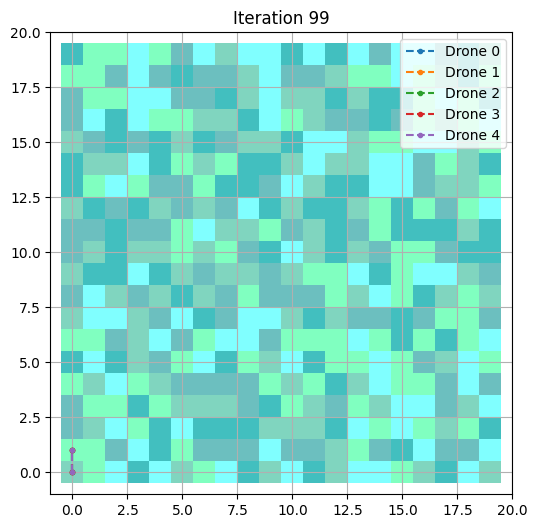

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

In [12]:
run_simulation()